In [1]:
import pandas as pd
import numpy as np
import csv
import glob
import os
import psycopg2 as pg

%matplotlib inline

//anaconda/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


In [2]:
### Group functions together, at top of notebook

# Define a function to label each row as a specific record type -- to use in .apply() 

def label_record(row):
    if row['a'][:3] == 'id,':
        return 'id'
    if row['a'][:5] == 'play,':
        return 'play'
    if row['a'][:8] == 'com,"ej,':
        return 'ejection comment'
    if row['a'][:3] == 'com':
        return 'other comment'
    return 'other'


# Define a function to generate a column of game_id's

def gen_id(row):
    if row['record_type'] == 'id':
        return row['a'][3:]


# Define a function to generate columns with individual data points from the play records

def gen_play(row, num): # num is the index of the list item of interest (i.e. of the items separated by commas)
    if row['record_type'] == 'play':
        return row['a'].split(',')[num]


# Define a function to generate columns with individual data points from ejection comments 

def gen_comment(row, num): # num is the index of the list item of interest (i.e. of the items separated by commas)
    if row['record_type'] == 'ejection comment':
        return row['a'].split(',')[num].strip('"')
    
# Define a function to create the ejection dataset for all years

def gen_ejection_data(filename):
    data = pd.read_table(filename, names='a')
    data = data[data.a.str[:3].isin(['id,','pla','com'])]
    data['record_type'] = data.apply(lambda row: label_record(row), axis=1)
    data['game_id'] = data.apply(lambda row: gen_id(row), axis=1).fillna(method='ffill')
       
    data['inning'] = data.apply(lambda row: gen_play(row, 1), axis=1)
    data['batting_team'] = data.apply(lambda row: gen_play(row, 2), axis=1)
    data['batter'] = data.apply(lambda row: gen_play(row, 3), axis=1)
    data['pitch_sequence'] = data.apply(lambda row: gen_play(row, 5), axis=1)
    data['event_text'] = data.apply(lambda row: gen_play(row, 6), axis=1)

    data['ejection_flag'] = data.apply(lambda row: gen_comment(row, 1), axis=1)
    data['ejectee'] = data.apply(lambda row: gen_comment(row, 2), axis=1)
    data['job_code'] = data.apply(lambda row: gen_comment(row, 3), axis=1)
    data['ump_id'] = data.apply(lambda row: gen_comment(row, 4), axis=1)
    data['reason'] = data.apply(lambda row: gen_comment(row, 5), axis=1)
    data = data.drop(data[data.event_text == 'NP'].index, axis=0)
    
    data = data.fillna(method='ffill')
    data = data[data.record_type == 'ejection comment']
    data = data.drop('a', axis=1)
    data = data.drop('record_type', axis=1)
    return data

In [3]:
test_data = pd.read_table('raw_data/2000BOS.EVA', names='a')
test_data.head()

,a
0,"id,BOS200004110"
1,"version,2"
2,"info,visteam,MIN"
3,"info,hometeam,BOS"
4,"info,site,BOS07"


In [4]:
### START HERE - 11/24/16
t = test_data.copy()
#t[t.a.str.startswith('sub,florb')]
#t = t.loc[5400:5410] # *** COMMENT OUT LATER ***
t = t[t.a.str[:3].isin(['id,','pla','com'])]
# insert line here that removes 'NP' records, too

t['record_type'] = t.apply(lambda row: label_record(row), axis=1)
t['game_id'] = t.apply(lambda row: gen_id(row), axis=1).fillna(method='ffill')
t['inning'] = t.apply(lambda row: gen_play(row, 1), axis=1)
t['batting_team'] = t.apply(lambda row: gen_play(row, 2), axis=1)
t['batter'] = t.apply(lambda row: gen_play(row, 3), axis=1)
t['pitch_sequence'] = t.apply(lambda row: gen_play(row, 5), axis=1)
t['event_text'] = t.apply(lambda row: gen_play(row, 6), axis=1)

t['ejection_flag'] = t.apply(lambda row: gen_comment(row, 1), axis=1)
t['ejectee'] = t.apply(lambda row: gen_comment(row, 2), axis=1)
t['job_code'] = t.apply(lambda row: gen_comment(row, 3), axis=1)
t['ump_id'] = t.apply(lambda row: gen_comment(row, 4), axis=1)
t['reason'] = t.apply(lambda row: gen_comment(row, 5), axis=1)
t = t.drop(t[t.event_text == 'NP'].index, axis=0) # OR: move up to be next line 3...

t = t.fillna(method='ffill')
t = t[t.record_type == 'ejection comment']
t = t.drop('a', axis=1)
t = t.drop('record_type', axis=1)
        
t

,game_id,inning,batting_team,batter,pitch_sequence,event_text,ejection_flag,ejectee,job_code,ump_id,reason
3511,BOS200005310,2,0,damoj001,BSFBX,D9/9LD.3-H;1-H;B-3(THH),ej,willj107,M,crawj901,Fan interference non-call
4648,BOS200006200,6,0,knobc001,BLX,2/BG/BINT.1-1,ej,knobc001,P,younl901,Interference call
5406,BOS200006280,10,1,varij001,CSX,7/F7,ej,willj107,M,reynj901,Balls and strikes
6303,BOS200007140,7,1,everc001,BFH,HP.1-2,ej,cookd001,P,fostm901,Arguing HBP
6428,BOS200007150,2,0,moram002,BC,CS2(24),ej,everc001,P,kulpr901,Bumping umpire during argument
7341,BOS200007230,7,1,lewid001,CBSBFX,53/G,ej,joshv101,C,bellw901,Balls and strikes
7342,BOS200007230,7,1,lewid001,CBSBFX,53/G,ej,manuj101,M,onorb901,Balls and strikes
11431,BOS200009201,7,1,daubb001,FSBX,43/G,ej,willj107,M,riekr901,Foul tip call
11781,BOS200009211,7,0,loftk001,BX,53/G,ej,manuc101,M,barkl901,Call at 1B


In [ ]:
BOS200006280 CSX
BOS200007230 CBSBFX
BOS200007230 CBSBFX

In [6]:
t = test_data.copy()
t = t.loc[5400:5410]
d = gen_ejection_data('raw_data/2000BOS.EVA')
d#.head()

,game_id,inning,batting_team,batter,pitch_sequence,event_text,ejection_flag,ejectee,job_code,ump_id,reason
3511,BOS200005310,2,0,damoj001,BSFBX,D9/9LD.3-H;1-H;B-3(THH),ej,willj107,M,crawj901,Fan interference non-call
4648,BOS200006200,6,0,knobc001,BLX,2/BG/BINT.1-1,ej,knobc001,P,younl901,Interference call
5406,BOS200006280,10,1,varij001,CSX,7/F7,ej,willj107,M,reynj901,Balls and strikes
6303,BOS200007140,7,1,everc001,BFH,HP.1-2,ej,cookd001,P,fostm901,Arguing HBP
6428,BOS200007150,2,0,moram002,BC,CS2(24),ej,everc001,P,kulpr901,Bumping umpire during argument
7341,BOS200007230,7,1,lewid001,CBSBFX,53/G,ej,joshv101,C,bellw901,Balls and strikes
7342,BOS200007230,7,1,lewid001,CBSBFX,53/G,ej,manuj101,M,onorb901,Balls and strikes
11431,BOS200009201,7,1,daubb001,FSBX,43/G,ej,willj107,M,riekr901,Foul tip call
11781,BOS200009211,7,0,loftk001,BX,53/G,ej,manuc101,M,barkl901,Call at 1B


In [4]:
# Create one ejection comment dataset, with rows from each year appended
# NOTE: RUNTIME IS APPX. 45 MINUTES

export_df = pd.DataFrame()

for filename in glob.iglob('raw_data/*.EV*'):
    year = filename[:4]
    team = filename[4:7]
    print("\nSource Table: " + filename)
        
    #path = 'raw_data/' 
    #if not os.path.exists(path):
    #    os.makedirs(path)
        
    raw_event_data = gen_ejection_data(filename)
    export_df = export_df.append(raw_event_data)

export_to_csv = export_df.to_csv(path_or_buf=path+'ejection_data_2000-2015.csv')


Source Table: 2000ANA.EVA

Source Table: 2000ARI.EVN

Source Table: 2000ATL.EVN

Source Table: 2000BAL.EVA


KeyboardInterrupt: 

In [ ]:
# Code used to clean up data issues with raw play-by-play files

data = pd.read_table('2013TEX.EVA', names='a')
data = data[data.a.str[:3].isin(['id,','pla','com'])]
data.loc[4640]

In [ ]:
# Useful text code to test correct ejection coding
# test1[test1.game_id == 'SFN201506160'].tail(30) # To find Pagan's/Bochy's ejections at the end; looks like it worked!

In [6]:
### Exploratory analysis of the ejections data, 2010-2015

ejection_df = pd.read_csv('team_csv_data/ejection_data_2000-2015.csv')
ejection_df = ejection_df.drop(ejection_df.columns[0], axis=1) # drop the old index column 
ejection_df.to_csv('team_csv_data/ejection_data_2000-2015_v2.csv', index=False) 
ejection_df.head()

,game_id,inning,batting_team,batter,pitch_sequence,event_text,ejection_flag,ejectee,job_code,ump_id,reason
0,ANA200004240,9,1,kenna001,FBFX,3(B)3(1)/LDP,ej,madlb001,C,welkb901,Balls and strikes
1,ANA200004240,2,0,polol001,X,46(1)/FO,ej,mansd801,C,culbf901,Call at 2B (Bumped umpire)
2,ANA200004240,5,1,glaut001,CCX,63/G,ej,garnp001,M,welkb901,Balls and strikes
3,ANA200005100,3,1,salmt001,BBX,63/G,ej,hatcm001,C,clara901,Fan interference call
4,ANA200007040,3,0,hendr001,CCFC,K/C,ej,hendr001,P,welkb901,Called third strike


In [7]:
e = ejection_df
len(e) # From 2000 through 2015, there were almost 3400 ejections

3394

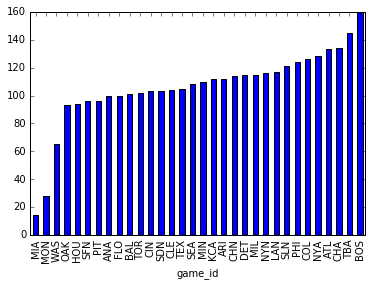

In [8]:
# Plot of total ejections by team
e.groupby(e.game_id.str[:3]).size().sort_values().plot(kind='bar')

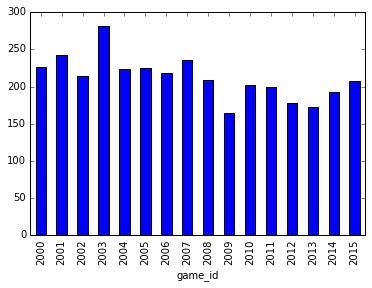

In [9]:
# Plot of number of total ejections per year
e.groupby(e.game_id.str[3:7]).size().plot(kind='bar')

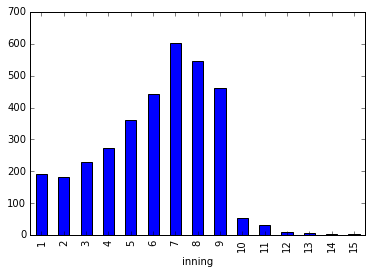

In [10]:
# Plot of ejections grouped by inning (most ejections occured in the 7th inning)
e.groupby(e.inning).size().plot(kind='bar')

In [11]:
# List of top 10 umpires for most ejections
e.groupby(e.ump_id).size().sort_values(ascending=False).head(10)

ump_id
fostm901    83
westj901    79
welkb901    76
timmt901    75
eddid901    74
drakr901    65
iassd901    65
gibsg901    64
wendh902    63
cuzzp901    62
dtype: int64

In [12]:
# Total ejections by job code
e.groupby(e.job_code).size().sort_values(ascending=False) # P = player, M = manager, C = coach, N = nonuniformed person

job_code
P    1634
M    1434
C     316
N       4
dtype: int64

In [19]:
# Top 10 reasons for someone getting ejected
e.groupby(e.reason).size().sort_values(ascending=False).head(10)
len(e.groupby(e.reason).size().sort_values(ascending=False))

# get down to much smaller set of reason, no more than 20, then start thinking about , classification problem
# Need to clean up/consolidate a lot of reason codings

683

In [14]:
e.job_code.describe()

count     3388
unique       4
top          P
freq      1634
Name: job_code, dtype: object

In [15]:
# Practice connecting to Postgres

conn = pg.connect("dbname=retrosheet user=danielgoodman") #connect and return connection
cur = conn.cursor()
source_table = 'ejections' # Name of table in retrosheet database

SQL_base = """SELECT
        *
    FROM 
        {source_table}
    
    ;"""
SQL_base = SQL_base.format(source_table=source_table)

test_query = pd.read_sql_query(SQL_base, conn) 
test_query.head()

,game_id,game_date,home_team_id,inn_ct,bat_home_id,bat_id,pitch_seq_tx,event_tx,ej_code,ejectee,job_code,ump_id,reason
0,ANA200004240,2000-04-24,ANA,9,True,kenna001,FBFX,3(B)3(1)/LDP,ej,madlb001,C,welkb901,Balls and strikes
1,ANA200004240,2000-04-24,ANA,2,False,polol001,X,46(1)/FO,ej,mansd801,C,culbf901,Call at 2B (Bumped umpire)
2,ANA200004240,2000-04-24,ANA,5,True,glaut001,CCX,63/G,ej,garnp001,M,welkb901,Balls and strikes
3,ANA200005100,2000-05-10,ANA,3,True,salmt001,BBX,63/G,ej,hatcm001,C,clara901,Fan interference call
4,ANA200007040,2000-07-04,ANA,3,False,hendr001,CCFC,K/C,ej,hendr001,P,welkb901,Called third strike


In [17]:
source_table = 'event'

SQL_query = """SELECT
        *
    FROM 
        {source_table} ev
    LEFT JOIN
        ejections ej
    ON ej.game_id = ev.game_id
        AND ej.inn_ct = ev.inn_ct
        AND ej.bat_id = ev.bat_id
        AND ej.pitch_seq_tx = ev.pitch_seq_tx
        AND ej.event_tx = ev.event_tx
    WHERE
        ev.game_id = 'ANA200007040'
    LIMIT 100
    ;"""
SQL_query = SQL_query.format(source_table=source_table)

ej_query = pd.read_sql_query(SQL_query, conn)
ej_query.head()

,event_uid,game_id,game_date,game_year,game_month,game_day_of_month,game_number,home_team_id,away_team_id,inn_ct,...,inn_ct,bat_home_id,bat_id,pitch_seq_tx,event_tx,ej_code,ejectee,job_code,ump_id,reason
0,ANA200007040001,ANA200007040,2000-07-04,2000,7,4,0,ANA,SEA,1,...,NaN,None,None,None,None,None,None,None,None,None
1,ANA200007040002,ANA200007040,2000-07-04,2000,7,4,0,ANA,SEA,1,...,NaN,None,None,None,None,None,None,None,None,None
2,ANA200007040003,ANA200007040,2000-07-04,2000,7,4,0,ANA,SEA,1,...,NaN,None,None,None,None,None,None,None,None,None
3,ANA200007040004,ANA200007040,2000-07-04,2000,7,4,0,ANA,SEA,1,...,NaN,None,None,None,None,None,None,None,None,None
4,ANA200007040005,ANA200007040,2000-07-04,2000,7,4,0,ANA,SEA,1,...,NaN,None,None,None,None,None,None,None,None,None
